In [2]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr


/tmp/ipykernel_1283758/3749613158.py:36: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [33]:
import subprocess
from datetime import datetime


In [3]:
def median_and_quantile(snrs):
    arr = np.array(list(snrs.values()))
    snrs['median'] = np.median(arr, 0)

    p10 = np.percentile(arr, 10, axis=0, method='linear')
    p90 = np.percentile(arr, 90, axis=0, method='linear')
    snrs['p10'] = p10
    snrs['p90'] = p90
    return snrs

def read_files(file_dict):
    outs = {}
    min_len = None
    for key, filename in file_dict.items():
        with open(filename, "r") as f:
            out = list(f)
        outs[key] = out
        if min_len is None:
            min_len = len(out)
        else:
            min_len = min(min_len, len(out))
    return outs, min_len

def read_metrics(outs, min_len):
    scores = {}
    snrs = {}
    ms, vs, gs = {}, {}, {}
    snrs_ema = {}
    snrs_adam_plus = {}
    pows_noise = {}
    data_dict = {}
    for key, out in outs.items():
        file_score = []
        file_snr = []
        file_m, file_v, file_g = [], [], []
        file_snrs_ema = []
        file_snrs_adam_plus = []
        file_pow_noise = []
        for i, line in enumerate(out):
            if i >= min_len-1:
                break
            if len(line.split()) > 15:
                match_pairs = dict(re.findall(r'(\w+):\s*([-\w.+e]+)', line))
                file_score.append(float(match_pairs['score']))
                file_snr.append(float(match_pairs['SNR']))
                file_m.append(float(match_pairs['m']))
                file_v.append(float(match_pairs['v']))
                file_g.append(float(match_pairs['g']))
                file_snrs_ema.append(float(match_pairs['EmaSNR']))
                if 'AdamPlusSNR' in match_pairs:
                    file_snrs_adam_plus.append(float(match_pairs['AdamPlusSNR']))
                else:
                    file_snrs_adam_plus.append(-np.inf)
                file_pow_noise.append(float(match_pairs['pow_noise']))
        scores[key] = file_score
        snrs[key] = file_snr
        ms[key] = file_m
        vs[key] = file_v
        gs[key] = file_g
        snrs_ema[key] = file_snrs_ema
        snrs_adam_plus[key] = file_snrs_adam_plus
        pows_noise[key] = file_pow_noise
        
    scores = median_and_quantile(scores)
    snrs = median_and_quantile(snrs)
    ms = median_and_quantile(ms)
    vs = median_and_quantile(vs)
    gs = median_and_quantile(gs)
    snrs_ema = median_and_quantile(snrs_ema)
    snrs_adam_plus = median_and_quantile(snrs_adam_plus)
    pows_noise = median_and_quantile(pows_noise)
    data_dict["Score"] = scores
#     data_dict["SNR"] = snrs
#     data_dict[r"$\|\widehat{\nabla J}\|$"] = gs
    data_dict[r"$\mathrm{SNR}_{Adam+}=\log(\bar{\mathrm{m}}^2/\bar{\mathrm{v}})$, dB"] = snrs_adam_plus
    data_dict[r"EMA(SNR), dB"] = snrs_ema
    data_dict[r"$\|\mathbf{m}\|$"] = ms
    data_dict[r"$\|\mathbf{v}\|$"] = vs
    data_dict["Noise Power"] = pows_noise
    return data_dict

def plot_metrics(axes, data_dict, label='Adam'):
    for ax, (ylabel, data) in zip(axes, data_dict.items()):
        num_points = len(data['median'])
        med = data['median']
        p10 = data['p10']
        p90 = data['p90']
        line, = ax.plot(med, label=label, alpha=0.7)
        color = line.get_color()
        ax.fill_between(range(num_points), p10, p90, color=color, alpha=0.1)
        ax.legend()
        ax.set_xlabel("Episode", fontsize=14)
        ax.set_ylabel(ylabel, fontsize=18)
        ax.tick_params(axis='both', labelsize=12)
        ax.grid(True)
        if ylabel in [r"$\|\mathbf{m}\|$", r"$\|\mathbf{v}\|$", r"$\|\widehat{\nabla J}\|$", "Noise Power"]:
            ax.set_yscale('log')  # Use log scale where necessary
    return axes

In [ ]:
# df.to_csv(os.path.join(outdir, "cartpole_DQN_Adam_AdamPlus_betas_2025_04_10.csv"))
# df.to_csv(os.path.join(outdir, "cartpole_VanillaDQN_Adam_AdamPlus_betas_2025_04_10_corrected.csv"))
# df.to_csv(os.path.join(outdir, "{}_VanillaDQN_Adam_AdamPlus_betas_2025_04_12_lr_decay_0.93_100.csv".format(games[0])))

In [4]:
def cifar_log_to_csv(log_text):
    
    pattern = r"\[(\d+),\s+(\d+)\] loss_tr: ([\d.]+) loss_te: ([\d.]+) acc_tr: ([\d.]+) acc_te: ([\d.]+)"
    data = re.findall(pattern, log_text)
    
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["epoch", "samples", "loss_tr", "loss_te", "acc_tr", "acc_te"])
    df = df.astype({
        "epoch": int,
        "samples": int,
        "loss_tr": float,
        "loss_te": float,
        "acc_tr": float,
        "acc_te": float
    })
    return df

In [13]:
# outdir2="./output/"
# txtfiles = os.listdir(outdir2)
# df = pd.DataFrame([])
# for txtfile in txtfiles:
#     fullpath = os.path.join(outdir2, txtfile)
#     if fullpath[-4:] != ".csv":
#         continue
#     with open(fullpath, 'r') as f:
#         log_text = f.read()
#     df_tmp = cifar_log_to_csv(log_text)
#     df_tmp["file"]=txtfile[0:-14]
#     df_tmp["mini_batch"] = df_tmp["epoch"]*400 + df_tmp["samples"]
#     df = pd.concat([df, df_tmp], ignore_index=False)

# df = df.reset_index(drop=True)
# df

In [1787]:
# envs = ["mnist-classifier"]
envs = ["resnet-18"]
csvfiles = os.listdir(output_dir)
df = pd.DataFrame([])
for csvfile in csvfiles:
    fullpath = os.path.join(output_dir, csvfile)
    if fullpath[-4:] != ".csv":
        continue
    cfgs = csvfile[0:-4].split("_")
    if len(cfgs) < 9:
        continue
    datas, env, optimizer, learning_rate, beta2, seed, dr, ds = cfgs[0], cfgs[1], cfgs[2], cfgs[3], cfgs[4], cfgs[5], cfgs[6], cfgs[7]
    batchsize = cfgs[-1]
    if env not in envs:
        continue
    if seed[4:] not in ["52"]:
        continue
    # if learning_rate not in ["1.0e-04","1.0e-03"]:
    if learning_rate not in ["1.0e-03"]:
        continue
    if dr not in ["1.0"]:
        continue
    if batchsize not in ["100"]:
        continue
    # if learning_rate not in ["1.0e-04"]:
    #     continue
    print(csvfile)
    df_tmp = pd.read_csv(fullpath, index_col=0)
    df_tmp["env"] = env
    df_tmp["opt"] = optimizer
    df_tmp["beta2"] = beta2
    df_tmp["mini_batch"] = (df_tmp["epoch"]-1)*500 + df_tmp["mini-batch"]
    df_tmp["file"]=csvfile[0:-4]
    df_tmp["step"] = df_tmp["mini_batch"]/500
    df = pd.concat([df, df_tmp], ignore_index=False)

df = df.reset_index(drop=True)
# new_df = df.groupby(["epoch", "opt", "beta2", "file"]).last().reset_index()
# new_df
# df

cifar10_resnet-18_AdamPlus_1.0e-03_0.9_seed52_1.0_1_100.csv
cifar10_resnet-18_Lamb_1.0e-03_0.9_seed52_1.0_1_100.csv
cifar10_resnet-18_AMSGrad_1.0e-03_0.999_seed52_1.0_1_100.csv
cifar10_resnet-18_Adam_1.0e-03_0.999_seed52_1.0_1_100.csv
cifar10_resnet-18_AdaBelief_1.0e-03_0.999_seed52_1.0_1_100.csv
cifar10_resnet-18_AdaBeliefW_1.0e-03_0.999_seed52_1.0_1_100.csv
cifar10_resnet-18_Adam_1.0e-03_0.9_seed52_1.0_1_100.csv
cifar10_resnet-18_Adopt_1.0e-03_0.999_seed52_1.0_1_100.csv
cifar10_resnet-18_Lion_1.0e-03_0.999_seed52_1.0_1_100.csv
cifar10_resnet-18_AdaGrad_1.0e-03_0.999_seed52_1.0_1_100.csv


In [1788]:
df_s1 = df.groupby(["opt","beta2"])[["runtime"]].median()
df_s2 = df.groupby(["opt","beta2"])[["epoch","mini_batch","acc_tr","acc_val"]].max()
df_s = pd.concat([df_s1,df_s2], axis=1)
df_s
# print(df.groupby(["opt","beta2"])[["loss_tr","loss_val"]].min())

runtime  epoch  mini_batch   acc_tr  acc_val
opt        beta2                                                 
AMSGrad    0.999   30.746410     56       28000  0.93114   0.9001
AdaBelief  0.999  161.021427      1         500  0.46126   0.5490
AdaBeliefW 0.999  157.506918      1         500  0.46434   0.5641
AdaGrad    0.999  155.620026      1         500  0.50246   0.6208
Adam       0.9    151.684123      1         500  0.47016   0.5004
           0.999  152.772407      1         500  0.47174   0.5133
AdamPlus   0.9    161.633999      1         500  0.43834   0.4901
Adopt      0.999  156.002634      1         500  0.48394   0.5442
Lamb       0.9    160.195355      1         500  0.48262   0.6184
Lion       0.999   29.827727     58       29000  0.98586   0.9185

In [1721]:
# result_file = os.path.join(output_dir, "mnist_cnn_results_all.csv")
# # df.to_csv(result_file)
# df = pd.read_csv(result_file, index_col=0)
# df

../fig/CIFAR_image_classification_cos_lr_loss_tr.pdf
../fig/CIFAR_image_classification_cos_lr_loss_val.pdf
../fig/CIFAR_image_classification_cos_lr_acc_tr.pdf
../fig/CIFAR_image_classification_cos_lr_acc_val.pdf


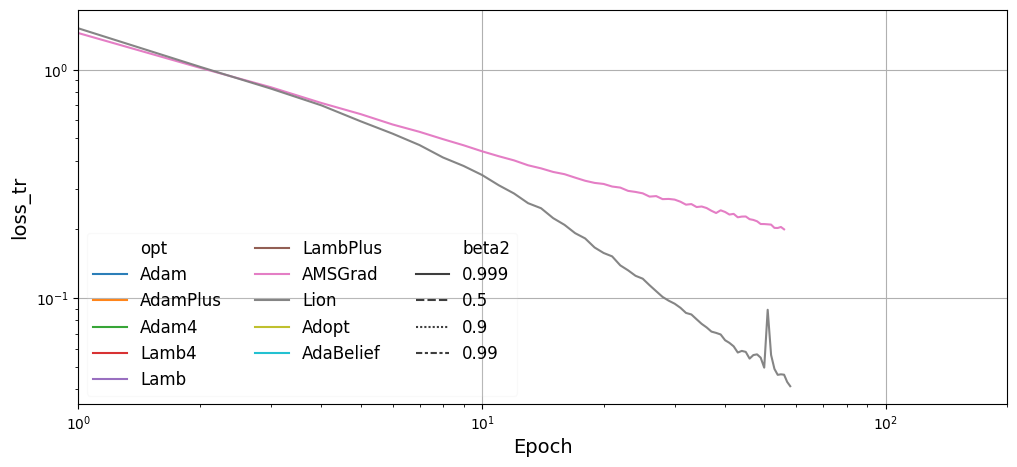

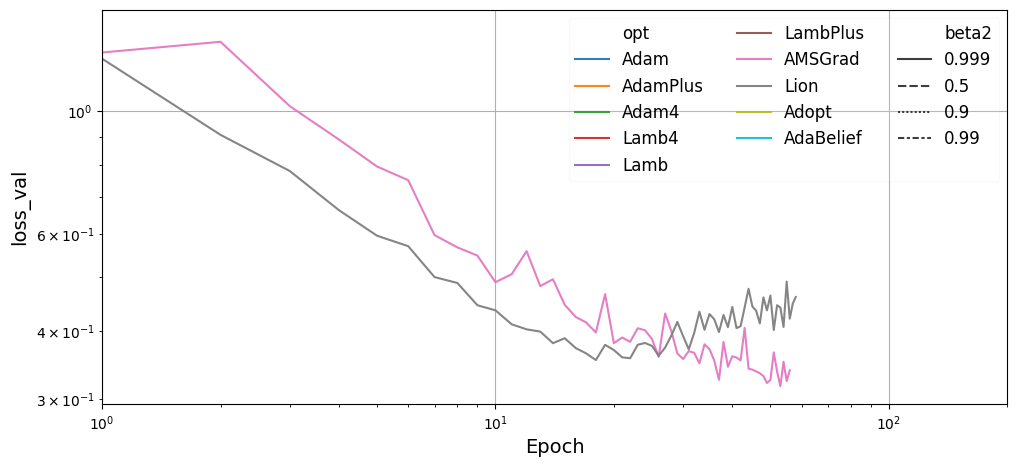

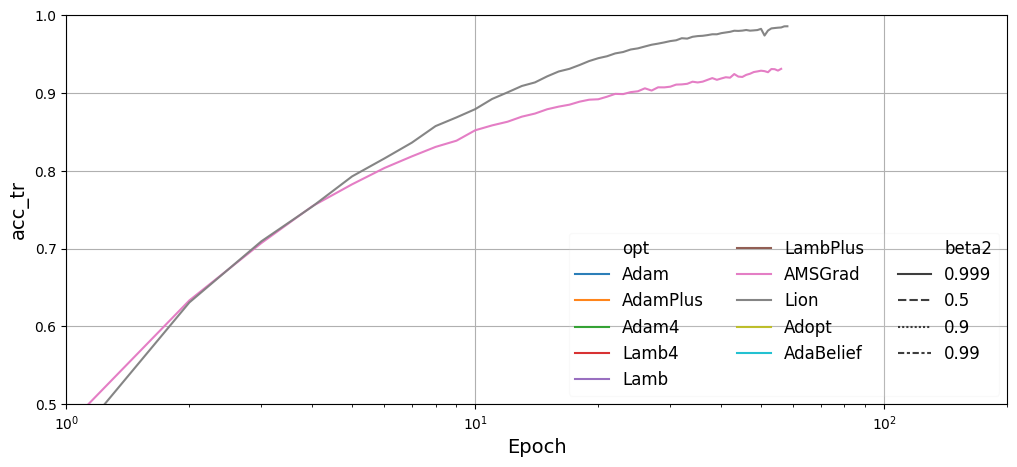

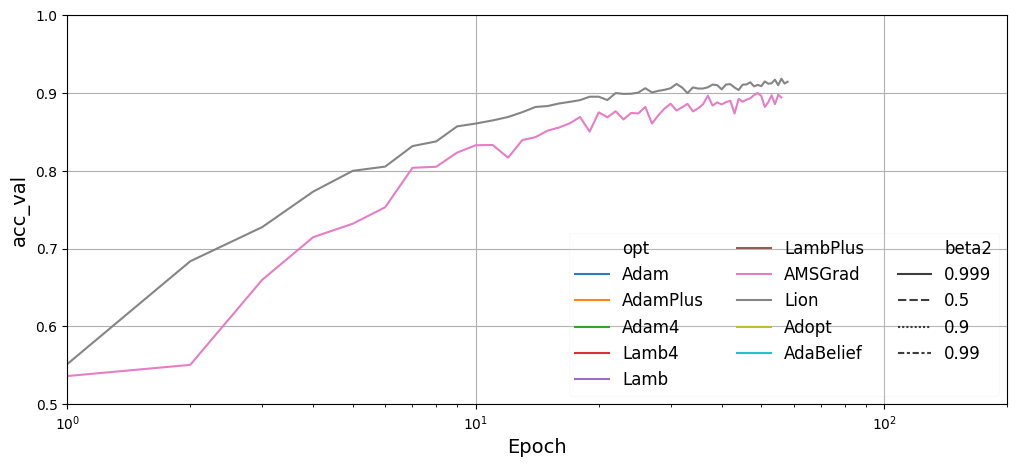

In [1789]:
item = "score"
# task = "MNIST_image_classification_fixed_lr_group1"
task = "CIFAR_image_classification_cos_lr"
# task = "CIFAR_image_classification_step_lr"
hue_order=["Adam", "AdamPlus", "Adam4","Lamb4", "Lamb", "LambPlus", "AMSGrad", "Lion", "Adopt", "AdaBelief"]

df_tmp = df
# df_tmp= df_tmp[df_tmp["beta2"]=="0.9"]
# df_tmp= df_tmp[df_tmp["seed"]=="seed35"]
# df_tmp= df[df["env"]=="lander"]
# for item in ["score", "EmaSNR", "AdamPlusSNR"]: 
for item in ["loss_tr", "loss_val", "acc_tr", "acc_val"]: 
# for item in ["loss_tr", "acc_tr", "acc_val"]: 
    fname = '../fig/{}_{}.pdf'.format(task, item)
    # fname = '../fig/AdamPlus_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 4.5))

    alpha = 0.025  # smoothing factor, tune this to adjust the amount of smoothing
    ema_col = f"{item}_ema"
    
    df_tmp[ema_col] = (
        df_tmp
        .groupby(["opt", "beta2"])[item]
        .transform(lambda x: x.ewm(alpha=alpha).mean())
    )
    
    # sns.lineplot(
    #     data=df_tmp, 
    #     # x="epoch", 
    #     x="step", 
    #     y=item, 
    #     hue="opt",
    #     hue_order=hue_order,
    #     # hue_order=["Adam", "AdamPlus", "Adam4","Adam42", "AdamW", "AdamW+", "AdamW4", "AdaBeliefW", "Lamb", "LambPlus"],
    #     # style="agent",
    #     # style_order=["DQN", "VanillaDQN"],
    #     style="beta2",
    #     style_order=["0.999","0.5","0.99","0.9"],
    #     palette="tab10", 
    #     errorbar=None,
    # #     markers=["o", "p", "*"],
    #     # markersize=14,
    # #     dashes=False,
    # #     linestyle="dotted",
    #     alpha=0.3,
    #     linewidth=0.2,
    #     ax=ax,
    #     legend=False,  # avoid duplicate legend entries
    # )
    
    # 2. Smoothed EMA curve (thicker and more prominent)
    sns.lineplot(
        data=df_tmp,
        x="step",
        y=item,
        # y=ema_col,
        hue="opt",
        style="beta2",
        style_order=["0.999", "0.5", "0.9", "0.99"],
        # hue_order=["Adam", "AdamPlus", "Lamb", "LambPlus", "AMSGrad", "Adam42",  "AdaBelief",  "Lion","Adam2",  "Adopt"],
        hue_order=hue_order,
        palette="tab10",
        errorbar=None,
        ax=ax,
        linewidth=1.5,
        alpha=0.95,
        # legend=False,  # avoid duplicate legend entries
    )    
        
    
    L = ax.legend(
        fontsize=12,
        framealpha=0.1,
        ncol=3,
        # loc='upper right',
    #     loc='lower right',
    )

    if item in ["loss_tr", "loss_val"]:
        plt.yscale("log")
        # ax.set_ylim([0.001,3])
    else:
        # ax.set_ylim([0.94, 1.0])
        ax.set_ylim([0.5, 1.0])
        pass
    # ax.get_legend().remove()
    # ax.set_ylim([-1000, 1])
    # ax.set_xlim([0, 180000])
    ax.grid(True)
    # ax.set_xlabel('Mini-batch', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(item, fontsize=14)
    ax.set_xlim([1, 200])
    plt.xscale("log")
    # ax.set_xlim([0, 100])
    
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')


In [1446]:
res_df = df_tmp.groupby(["opt","beta2"])[["runtime"]].mean()
res_df2 = df_tmp.groupby(["opt","beta2"])[["epoch","mini_batch","acc_tr_ema","acc_val_ema"]].max()
res_df3 = df_tmp.groupby(["opt","beta2"])[["loss_tr_ema","loss_val_ema"]].min()
res_df = pd.concat([res_df, res_df2, res_df3], axis=1)
res_df = res_df.reset_index()
res_df.to_csv(os.path.join(output_dir,"mnist_cnn_result_table.csv"))
res_df

,opt,beta2,runtime,epoch,mini_batch,acc_tr_ema,acc_val_ema,loss_tr_ema,loss_val_ema
0,AMSGrad,0.999,0.727369,100,180000,0.995918,0.989935,0.015979,0.029909
1,AdaBelief,0.999,0.372633,100,180000,0.996982,0.989989,0.012254,0.029726
2,AdaBeliefW,0.999,0.891324,100,180000,0.999747,0.989562,0.000987,0.037186
3,AdaBound,0.999,0.942012,100,180000,0.993955,0.990272,0.020150,0.029412
4,AdaGrad,0.999,0.520170,100,180000,0.970998,0.973845,0.098330,0.087346
5,Adam,0.5,0.727693,100,180000,0.987379,0.986247,0.042460,0.041452
6,Adam,0.9,0.729141,100,180000,0.994458,0.989786,0.019516,0.029971
7,Adam,0.999,0.296443,100,180000,0.996851,0.990345,0.012793,0.028464
8,Adam4,0.5,1.078570,100,180000,0.992711,0.989651,0.024381,0.029806
9,Adam4,0.9,1.014908,100,180000,0.994607,0.990751,0.018634,0.028337


In [1464]:
# res_df[res_df["beta2"]=="0.999"].sort_values(by=["acc_val_ema"])
res_df.sort_values(by=["loss_val_ema"])

,opt,beta2,runtime,epoch,mini_batch,acc_tr_ema,acc_val_ema,loss_tr_ema,loss_val_ema
32,Lamb,0.999,0.958501,100,180000,0.996453,0.990672,0.013265,0.027362
38,LambPlus,0.999,1.224701,100,180000,0.996524,0.990637,0.013352,0.027453
37,LambPlus,0.9,0.925049,100,180000,0.994358,0.990807,0.019182,0.027533
35,Lamb4,0.999,1.000254,100,180000,0.996066,0.990711,0.014242,0.027665
9,Adam4,0.9,1.014908,100,180000,0.994607,0.990751,0.018634,0.028337
7,Adam,0.999,0.296443,100,180000,0.996851,0.990345,0.012793,0.028464
31,Lamb,0.9,0.973033,100,180000,0.994306,0.990646,0.019361,0.028533
13,Adam42,0.9,1.036280,100,180000,0.992862,0.990546,0.023602,0.028653
29,Adopt,0.999,0.757724,100,180000,0.996872,0.990123,0.012499,0.029078
16,AdamPlus,0.999,1.048320,100,180000,0.996773,0.990192,0.012722,0.029262


In [1457]:
# Identify the best (maximum acc_val_ema) beta2 per optimizer
best_combinations = (
    res_df.loc[res_df.groupby("opt")["acc_val_ema"].idxmax()]
)

# Display the selected combinations
# best_combinations.sort_values(by=["acc_val_ema"])
best_combinations.sort_values(by=["loss_val_ema"])

,opt,beta2,runtime,epoch,mini_batch,acc_tr_ema,acc_val_ema,loss_tr_ema,loss_val_ema
32,Lamb,0.999,0.958501,100,180000,0.996453,0.990672,0.013265,0.027362
37,LambPlus,0.9,0.925049,100,180000,0.994358,0.990807,0.019182,0.027533
35,Lamb4,0.999,1.000254,100,180000,0.996066,0.990711,0.014242,0.027665
9,Adam4,0.9,1.014908,100,180000,0.994607,0.990751,0.018634,0.028337
7,Adam,0.999,0.296443,100,180000,0.996851,0.990345,0.012793,0.028464
13,Adam42,0.9,1.036280,100,180000,0.992862,0.990546,0.023602,0.028653
29,Adopt,0.999,0.757724,100,180000,0.996872,0.990123,0.012499,0.029078
3,AdaBound,0.999,0.942012,100,180000,0.993955,0.990272,0.020150,0.029412
15,AdamPlus,0.9,1.020421,100,180000,0.994793,0.990267,0.018376,0.029652
1,AdaBelief,0.999,0.372633,100,180000,0.996982,0.989989,0.012254,0.029726


In [1440]:
show_combs = best_combinations[best_combinations.index.isin([7, 9, 32, 34, 4, 0, 2, 36, 29, 3, 28, 19])]

In [1441]:
# Filter df_tmp using the selected best (opt, beta2) combinations
df_filtered = df_tmp.merge(show_combs[["opt", "beta2"]])
df_filtered

,epoch,mini-batch,loss_tr,loss_val,acc_tr,acc_val,SNR,EmaSNR,AdamPlusSNR,m,...,env,opt,beta2,mini_batch,file,step,loss_tr_ema,loss_val_ema,acc_tr_ema,acc_val_ema
0,1,100,2.283509,2.247232,0.195625,0.3499,NaN,NaN,NaN,NaN,...,mnist-classifier,AdaBound,0.999,100,mnist-classifier_AdaBound_1.0e-04_0.999_seed51...,0.055556,2.283509,2.247232,0.195625,0.349900
1,1,200,2.059453,1.581118,0.552500,0.7198,NaN,NaN,NaN,NaN,...,mnist-classifier,AdaBound,0.999,200,mnist-classifier_AdaBound_1.0e-04_0.999_seed51...,0.111111,2.170063,1.909959,0.376321,0.537191
2,1,300,0.936037,0.568141,0.740313,0.8278,NaN,NaN,NaN,NaN,...,mnist-classifier,AdaBound,0.999,300,mnist-classifier_AdaBound_1.0e-04_0.999_seed51...,0.166667,1.748264,1.451316,0.500736,0.636523
3,1,400,0.505101,0.448648,0.844063,0.8653,NaN,NaN,NaN,NaN,...,mnist-classifier,AdaBound,0.999,400,mnist-classifier_AdaBound_1.0e-04_0.999_seed51...,0.222222,1.425573,1.191051,0.589854,0.695908
4,1,500,0.415881,0.345791,0.876563,0.9006,NaN,NaN,NaN,NaN,...,mnist-classifier,AdaBound,0.999,500,mnist-classifier_AdaBound_1.0e-04_0.999_seed51...,0.277778,1.213282,1.013332,0.650136,0.738945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19795,100,1400,0.024801,0.028440,0.992188,0.9907,NaN,NaN,NaN,NaN,...,mnist-classifier,Adam4,0.9,179600,mnist-classifier_Adam4_1.0e-04_0.9_seed51_1.0_...,99.777778,0.019148,0.028556,0.994430,0.990655
19796,100,1500,0.024445,0.026191,0.991875,0.9923,NaN,NaN,NaN,NaN,...,mnist-classifier,Adam4,0.9,179700,mnist-classifier_Adam4_1.0e-04_0.9_seed51_1.0_...,99.833333,0.019280,0.028497,0.994366,0.990696
19797,100,1600,0.018973,0.026541,0.994062,0.9911,NaN,NaN,NaN,NaN,...,mnist-classifier,Adam4,0.9,179800,mnist-classifier_Adam4_1.0e-04_0.9_seed51_1.0_...,99.888889,0.019272,0.028448,0.994358,0.990706
19798,100,1700,0.015274,0.025836,0.995000,0.9916,NaN,NaN,NaN,NaN,...,mnist-classifier,Adam4,0.9,179900,mnist-classifier_Adam4_1.0e-04_0.9_seed51_1.0_...,99.944444,0.019172,0.028383,0.994374,0.990729


../fig/MNIST_image_classification_fixed_lr_group2_loss_tr.pdf
../fig/MNIST_image_classification_fixed_lr_group2_loss_val.pdf
../fig/MNIST_image_classification_fixed_lr_group2_acc_tr.pdf
../fig/MNIST_image_classification_fixed_lr_group2_acc_val.pdf


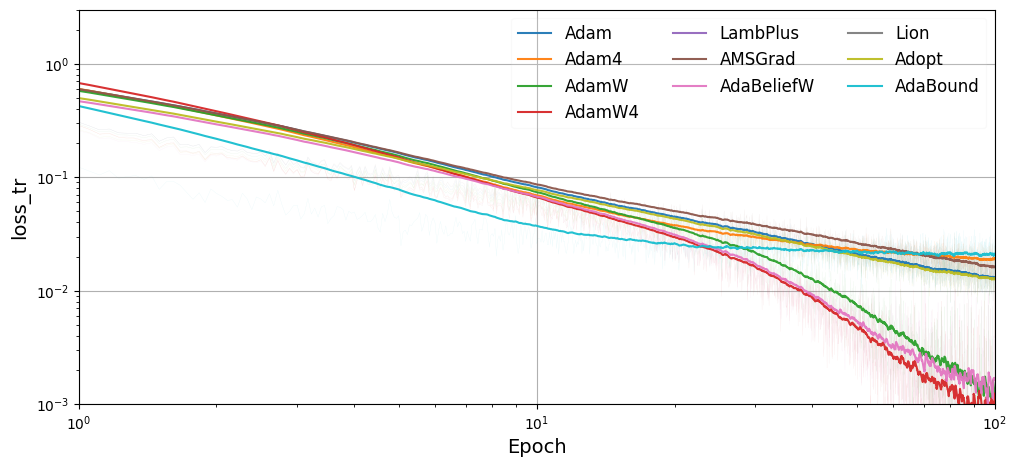

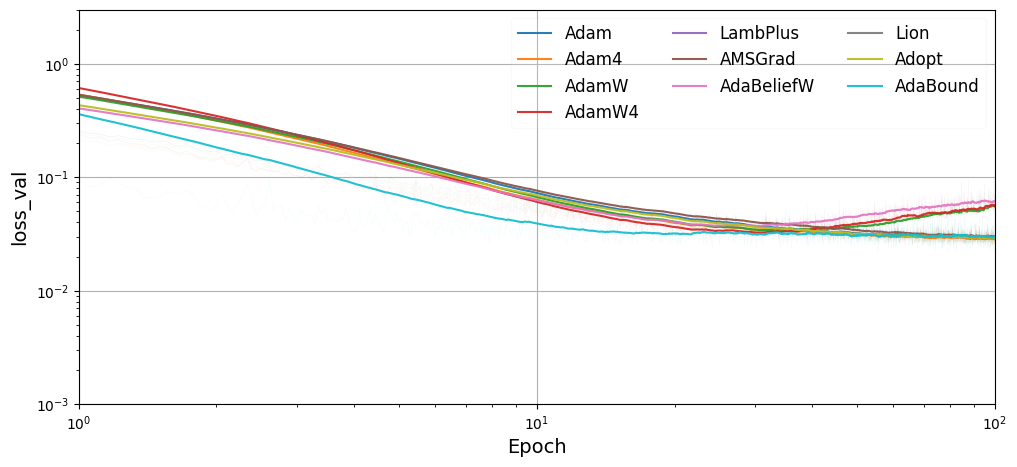

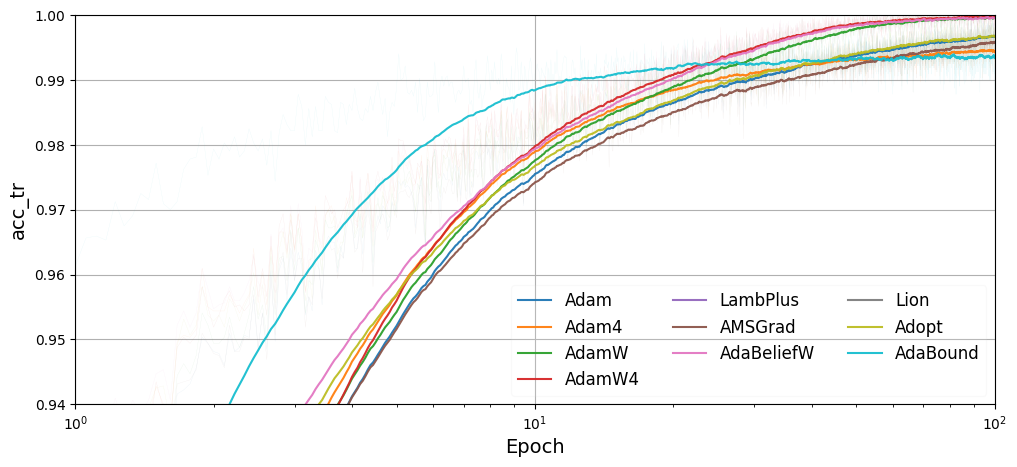

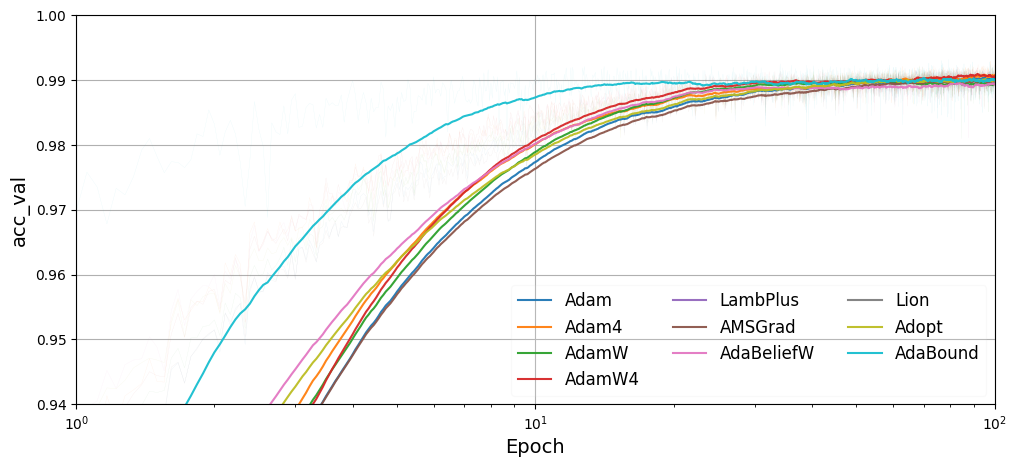

In [1442]:
item = "score"
task = "MNIST_image_classification_fixed_lr_group2"
# task = "CIFAR_image_classification_step_lr"

df_tmp = df_filtered
# df_tmp= df_tmp[df_tmp["beta2"]=="0.9"]
# df_tmp= df_tmp[df_tmp["seed"]=="seed35"]
# df_tmp= df[df["env"]=="lander"]
# for item in ["score", "EmaSNR", "AdamPlusSNR"]: 
for item in ["loss_tr", "loss_val", "acc_tr", "acc_val"]: 
# for item in ["loss_tr", "acc_tr", "acc_val"]: 
    fname = '../fig/{}_{}.pdf'.format(task, item)
    # fname = '../fig/AdamPlus_{}_seeds_32-36_{}.pdf'.format(games[0], item)
    fig, ax = plt.subplots(1, 1, sharey=False, figsize=(10, 4.5))

    alpha = 0.025  # smoothing factor, tune this to adjust the amount of smoothing
    ema_col = f"{item}_ema"
    
    df_tmp[ema_col] = (
        df_tmp
        .groupby(["opt", "beta2"])[item]
        .transform(lambda x: x.ewm(alpha=alpha).mean())
    )
    
    sns.lineplot(
        data=df_tmp, 
        # x="epoch", 
        x="step", 
        y=item, 
        hue="opt",
        # hue_order=["Adam", "AdamPlus", "Adam4","Adam42", "AdamW", "AdamW+", "AdamW4", "AdaBeliefW", "Lamb", "LambPlus"],
        hue_order=["Adam", "Adam4", "AdamW", "AdamW4", "LambPlus", "AMSGrad", "AdaBeliefW",  "Lion",  "Adopt", "AdaBound"],
        # style="agent",
        # style_order=["DQN", "VanillaDQN"],
        # style="beta2",
        # style_order=["0.999","0.5","0.99","0.9"],
        palette="tab10", 
        errorbar=None,
    #     markers=["o", "p", "*"],
        # markersize=14,
    #     dashes=False,
    #     linestyle="dotted",
        alpha=0.1,
        linewidth=0.2,
        ax=ax,
        legend=False,  # avoid duplicate legend entries
    )
    
    # 2. Smoothed EMA curve (thicker and more prominent)
    sns.lineplot(
        data=df_tmp,
        x="step",
        y=ema_col,
        hue="opt",
        # style="beta2",
        # style_order=["0.999", "0.5", "0.9", "0.99"],
        hue_order=["Adam", "Adam4", "AdamW", "AdamW4", "LambPlus", "AMSGrad", "AdaBeliefW",  "Lion",  "Adopt", "AdaBound"],
        # hue_order=["Adam", "AdamPlus", "Lamb", "LambPlus", "AMSGrad", "Adam42",  "AdaBelief",  "Lion","Adam2",  "Adopt"],
        # hue_order=["Adam", "AdamPlus", "Adam4","Adam41","Adam42", "Lamb", "LambPlus", "AMSGrad", "AdaBelief",  "Lion",  "Adopt","Adam2", "AdaBound", "AdamW","AdamW+"],
        palette="tab10",
        errorbar=None,
        ax=ax,
        linewidth=1.5,
        alpha=0.95,
        # legend=False,  # avoid duplicate legend entries
    )    
        
    
    L = ax.legend(
        fontsize=12,
        framealpha=0.1,
        ncol=3,
        # loc='upper right',
    #     loc='lower right',
    )

    if item in ["loss_tr", "loss_val"]:
        plt.yscale("log")
        ax.set_ylim([0.001,3])
    else:
        ax.set_ylim([0.94, 1.0])
    # ax.get_legend().remove()
    # ax.set_ylim([-1000, 1])
    # ax.set_xlim([0, 180000])
    ax.set_xlim([1, 100])
    ax.grid(True)
    # ax.set_xlabel('Mini-batch', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel(item, fontsize=14)
    plt.xscale("log")
    
    print(fname)
    # fig.set_size_inches(5.5, 4.5)
    plt.tight_layout(pad=0.1)
    fig.savefig(fname,
                dpi=300,  # facecolor='w', edgecolor='w',
                orientation='portrait',
                format='pdf')
